# Hoti

In [1]:
from pylab import *
import matplotlib.pylab as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib import rc


font = {'family' : 'serif',
        'serif': ['Computer Modern'],
        'weight' : 'bold',
        'size'   : 28}

rc('font', **font)
rc('text', usetex=True)

In [2]:
import os

if not os.path.exists("images"):
    os.mkdir("images")

if not os.path.exists("images/video_images"):
    os.mkdir("images/video_images")
    
if not os.path.exists("images/video_images2"):
    os.mkdir("images/video_images2")

if not os.path.exists("images/video_images3"):
    os.mkdir("images/video_images3")

In [40]:
name_array = "LatticeSierpinski_6x6.xyz"
epsi = 0.00
nval = 0.1
val  = 1
cal_value = True

In [41]:
Color_array = ['rgb(30, 150, 0)',
              'rgb(63, 161, 0)',
              'rgb(89, 172, 0)',
              'rgb(113, 182, 0)',
              'rgb(136, 193, 0)',
              'rgb(159, 203, 0)',
              'rgb(183, 213, 0)',
              'rgb(206, 223, 0)',
              'rgb(230, 233, 0)',
              'rgb(255, 242, 0)',
              'rgb(255, 225, 0)',
               'rgb(255, 208, 0)',
               'rgb(255, 190, 0)',
               'rgb(255, 172, 0)',
               'rgb(255, 153, 0)',
               'rgb(255, 133, 0)',
               'rgb(255, 112, 0)',
               'rgb(255, 88, 0)',
               'rgb(255, 59, 0)',
               'rgb(255, 0, 0)']

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll


def colorline(
        x, y, axis, z=None ,cmap='copper',
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    # to check for numerical input -- this is a hack
    if not hasattr(z, "__iter__"):
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap,
                              linewidth=linewidth, alpha=alpha)

    axis.add_collection(lc)

    return lc

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments



# Modelo finito 

In [43]:
x,y,f,d = np.loadtxt(name_array,usecols=(1,2,4,5),skiprows=2,unpack=True)
ind = np.argsort(f)
#x,y,f = xd[ind], yd[ind], fd[ind]

In [44]:
r = 1.1
Dic = {}
natoms = int( len(x) )
for n in range(natoms):
    a = sqrt( (x[n]-x)*(x[n]-x) + (y[n]-y)*(y[n]-y) ) < r 
    vecinos = [i for i, x in enumerate(a) if x and i!=n]
    Dic[n] = vecinos

In [45]:
r = max(x) - 0.1
Dic_further = {}
for n in range(natoms):
    a = sqrt( (x[n]-x)*(x[n]-x) + (y[n]-y)*(y[n]-y) ) > r
    vecinos = [i for i, j in enumerate(a) if j and (x[n]==x[i] or y[n]==y[i])]
    Dic_further[n] = vecinos

In [46]:
#random matrix
M_rand = rand(natoms,natoms)
M_rand = (M_rand + M_rand.T)/2
M_mins = diag(ones(natoms))

M_rand = M_rand - M_mins*M_rand

In [47]:
def Hoti_Hamiltonian_transport(A,θ,γ, ϵ=epsi,δ=0.5, natoms=natoms, M_rand=M_rand, conection=False):
    H = np.zeros((natoms,natoms), dtype = 'complex')
    Hop = {}
    a = exp(-1J*pi)
    λ = 1
    
    
    A   = 0.5     # μm
    def func_cext(θ,A,λ):
        return  λ*exp(-(1+A*cos(θ)))

    def func_cint(θ,A,γ):
        return γ*exp(-(1-A*cos(θ)))


    
    for n in Dic.keys():
        vecinos = Dic[n]
        hop = []
        for v in vecinos:
            f0 = f[n]
            f1 = f[v]
            
            if y[n] == y[v]:
                if f0 == f1:
                    fase = func_cint(θ,A,γ)
                else: 
                    fase = func_cext(θ,A,λ)
            else:
                if f0 == f1:
                    fase = γ
                else: 
                    fase = λ
            
            H[n,v] = fase 
            H[v,n] = fase 
            
            
            hop.append(fase)
        Hop[n] = hop

    f0 = 0
    f1 = 0
    fase = 1
    for n in Dic.keys():
        vecinos = Dic[n]
        for v in vecinos:
            posx     = x[n]
            posy     = y[n]
            f0       = f[n]
            f1       = f[v] 
            
            if y[n] == y[v]:
                if f0 == f1:
                    fase = func_cint(θ,A,γ)
                else: 
                    fase = func_cext(θ,A,λ)
            else:
                if f0 == f1:
                    fase = γ
                else: 
                    fase = λ
                
                
            if ( posy%2==0  ):
                  if ( x[v] > x[n] ):
                    H[n,v] = a*fase 
                    H[v,n] = a*fase 
            #elif(posx%2==1 and posy%2==1):
               # if ( x[v] > x[n] ):
              #      H[n,v] = a*fase 
             #       H[v,n] = a*fase 
            else:
                pass
    
    if conection : 
        #print('some')
        for n in Dic_further.keys():
            vecinos = Dic_further[n]
            for v in vecinos:
                posx   = x[n]
                posy   = y[n]
                
                if y[n] == y[v]:
                    fase = func_cext(θ,A,λ)
                else:
                    fase = λ
               
                H[n,v] = fase 
                H[v,n] = fase 

                if(posy%2==1):
                    if ( x[v] < x[n] ):
                        H[n,v] = a*fase 
                        H[v,n] = a*fase 
                else:
                    pass
                
    H_delta = δ*sin(θ)*array(d)
    H_delta = diag(resize(H_delta,natoms), k=0)
    #print(H_delta)
    if ϵ > 0.0:
        H_rand = H * ϵ * M_rand 
        return H + H_rand + H_delta
    else:    
        return H + H_delta
    #print(H)

In [48]:
def wave_function(Ek,U,arg='all'):
    Est  = argsort(abs(Ek))[0:4]
    if arg == 'pos':
        Est = Est[Ek[Est]>0]
    elif arg == 'neg':
        Est = Est[Ek[Est]<0]
    ek = np.mean(Ek[Est])
    s = [np.real(U[i]*U.conjugate()[i]) for i in Est]
    S = np.zeros(len(s[0]))
    for i in range(len(s)):
        S += s[i] 
    S = S/sum(S)
    Est = Est
    return S,Est

In [49]:
def density_of_states(Ek,U,arg='all'):
    indexsort = argsort(Ek)
    Est  = argsort(abs(Ek))[0:4]
    if arg == 'pos':
        Est = Est[Ek[Est]>0]
    elif arg == 'neg':
        Est = Est[Ek[Est]<0]
    #Est = [i for i,val in enumerate(Ek) if abs(val) < 0.2]
    #print(Est)
    ek = np.mean(Ek[Est])
    s = [np.real(U[i]*U.conjugate()[i]) for i in Est]
    S = np.zeros(len(s[0]))
    for i in range(len(s)):
        S += s[i] 
    S = S/sum(S)
    return S

In [50]:
def density_of_states_array(Ek,U):
    indexsort = argsort(Ek)
    #Est = [i for i,val in enumerate(Ek) if abs(val) < 0.2]
    ek = np.mean(Ek[Est])
    s = [np.real(U[i]*U.conjugate()[i]) for i in Est]
    S = np.zeros(len(s[0]))
    for i in range(len(s)):
        S += s[i] 
    S = S/sum(S)
    #print(Est)
    return s

# Modelo Infinito

In [51]:
def SSH(kx,ky,γ,λ):
    δ = 1e-5
    H = np.array([[δ,γ+λ*exp(-1J*kx),0,γ-λ*exp(1J*ky)],
                  [γ+λ*exp(1J*kx),-δ,-γ+λ*exp(1J*ky),0],
                  [0,-γ+λ*exp(-1J*ky),-δ,γ+λ*exp(1J*kx)],
                  [γ-λ*exp(-1J*ky),0,γ+λ*exp(-1J*kx),δ]])
    return H

# High Order Topological Pump

In [52]:
A  = 0.5
H0 = Hoti_Hamiltonian_transport(A,-pi,0.5)
H1 = Hoti_Hamiltonian_transport(A,0,0.5)
H2 = Hoti_Hamiltonian_transport(A,pi,0.5)

Ek0, U0 = eigh(H0)
Ek0 = np.real(Ek0)

Ek1, U1 = eigh(H1)
Ek1 = np.real(Ek1)

Ek2, U2 = eigh(H2)
Ek2 = np.real(Ek2)

savetxt("E0_pump.txt",Ek0,fmt = '%s', comments = '')
savetxt("Est0_pump.txt",U0,fmt = '%s', comments = '')

savetxt("E1_pump.txt",Ek1,fmt = '%s', comments = '')
savetxt("Est1_pump.txt",U1,fmt = '%s', comments = '')

savetxt("E2_pump.txt",Ek2,fmt = '%s', comments = '')
savetxt("Est2_pump.txt",U2,fmt = '%s', comments = '')

In [53]:
Ek0 = loadtxt("E0_pump.txt", unpack=True)
U0  = loadtxt("Est0_pump.txt", dtype=complex, unpack=True)

Ek1 = loadtxt("E1_pump.txt", unpack=True)
U1  = loadtxt("Est1_pump.txt", dtype=complex, unpack=True)

Ek2 = loadtxt("E2_pump.txt", unpack=True)
U2  = loadtxt("Est2_pump.txt", dtype=complex, unpack=True)

In [54]:
W0,Est = wave_function(Ek0,U0)

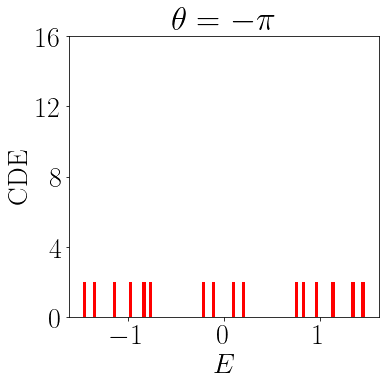

In [55]:
fig, ax = plt.subplots(figsize=(6,6))
bins = 85
ax.hist(Ek0,bins, facecolor='r')
ax.set_ylabel('CDE')
ax.set_xlabel('$E$')
ax.set_yticks([0,4,8,12,16])
ax.set_title('$\\theta = -\pi$')

plt.tight_layout()
plt.savefig('images/bars_square_pump1.pdf')
plt.savefig('images/bars_square_pump1.png')

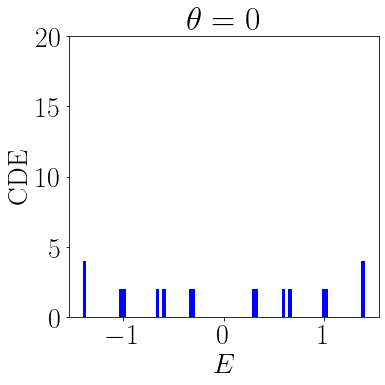

In [56]:
fig, ax = plt.subplots(figsize=(6,6))
bins = 85
ax.hist(Ek1,bins, facecolor='b')
ax.set_ylabel('CDE')
ax.set_xlabel('$E$')
ax.set_yticks([0,5,10,15,20])
ax.set_title('$\\theta = 0$')

plt.tight_layout()
plt.savefig('images/bars_square_pump2.pdf')
plt.savefig('images/bars_square_pump2.png')

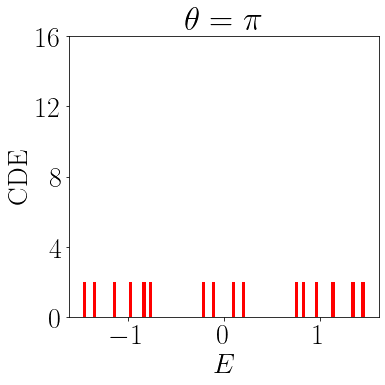

In [57]:
fig, ax = plt.subplots(figsize=(6,6))
bins = 85
ax.hist(Ek2,bins, facecolor='r')
ax.set_ylabel('CDE')
ax.set_xlabel('$E$')
ax.set_yticks([0,4,8,12,16])
ax.set_title('$\\theta = \pi$')

plt.tight_layout()
plt.savefig('images/bars_square_pump3.pdf')
plt.savefig('images/bars_square_pump3.png')

In [58]:
E_θ = []
posx = []
for θ in linspace(-pi,pi,51):
    H = Hoti_Hamiltonian_transport(0.5,θ,nval)
    Ek, U = eigh(H)
    Ek = np.real(Ek)
    indexsort = argsort(Ek)
    E_θ.append(Ek[indexsort])
    posx.append(θ)
E = array(E_θ)    
savetxt("param_bands_pump.txt",E,fmt = '%s', comments = '')


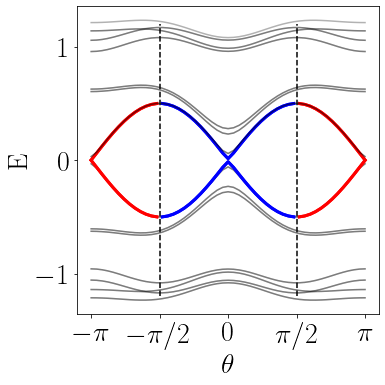

In [59]:
E = loadtxt("param_bands_pump.txt",unpack=True)
fig,ax = plt.subplots(figsize=(6,6))
for i in range(n):
    Param = linspace(-pi,pi,51)
    if i in Est:
        PM = [j for j in range(len(Param)) if Param[j]>=pi/2]
        Pm = [j for j in range(len(Param)) if Param[j]<=-pi/2]
        Pc = [j for j in range(len(Param)) if abs(Param[j])<=pi/2]
        ax.plot(Param[Pm],E[i][Pm],lw=3,c='red')
        ax.plot(Param[PM],E[i][PM],lw=3, c='red')
        ax.plot(Param[Pc],E[i][Pc],lw=3, c='blue')
    else:
        ax.plot(Param,E[i], c='black', alpha=0.3)
        
ax.plot([-pi/2,-pi/2],[-1.2,1.2],ls='--', c='black')
ax.plot([pi/2,pi/2],[-1.2,1.2],ls='--', c='black')
ax.set_xticks([-pi,-pi/2,0,pi/2,pi])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$'])    
ax.set_xlabel('$\\theta$')
ax.set_ylabel('E')
#ax.set_title('a)',loc='left')
plt.tight_layout()
plt.savefig('images/param_pump_A=0.5.png')
plt.savefig('images/param_pump_A=0.5.pdf')



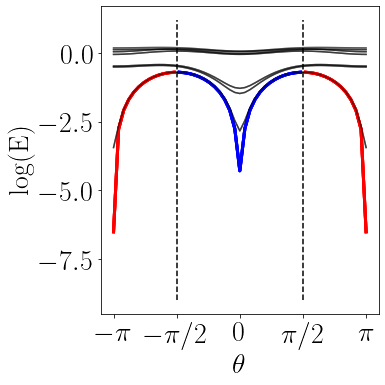

In [60]:
E = loadtxt("param_bands_pump.txt",unpack=True)
fig,ax = plt.subplots(figsize=(6,6))
for i in range(n):
    Param = linspace(-pi,pi,51)
    if i in Est:
        PM = [j for j in range(len(Param)) if Param[j]>=pi/2]
        Pm = [j for j in range(len(Param)) if Param[j]<=-pi/2]
        Pc = [j for j in range(len(Param)) if abs(Param[j])<=pi/2]
        ax.plot(Param[Pm],log(abs(E[i]))[Pm],lw=3,c='red')
        ax.plot(Param[PM],log(abs(E[i]))[PM],lw=3, c='red')
        ax.plot(Param[Pc],log(abs(E[i]))[Pc],lw=3, c='blue')
    else:
        ax.plot(Param,log(abs(E[i])), c='black',alpha=0.3)
        
ax.plot([-pi/2,-pi/2],[-9,1.2],ls='--', c='black')
ax.plot([pi/2,pi/2],[-9,1.2],ls='--', c='black')
ax.set_xticks([-pi,-pi/2,0,pi/2,pi])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$'])    
ax.set_xlabel('$\\theta$')
ax.set_ylabel('log(E)')
#ax.set_title('a)',loc='left')
plt.tight_layout()
plt.savefig('images/param_pump_A=0.5_log.png')
plt.savefig('images/param_pump_A=0.5_log.pdf')

# Corriente por cuadrante
$$ R(\nabla \cdot J) = \frac{d\rho}{dt}R$$

$$ R \cdot R(\nabla \cdot J) = \frac{d\rho}{dt}R \cdot R$$

$$ \frac{R \cdot R}{|R|^2}(\nabla \cdot J_{cell}) = \frac{d\rho_{cell}}{dt}\frac{R \cdot R}{|R|^2}$$


$$\int J_{cell} \cdot dA = \int \frac{d\rho_{cell}}{dt} dV$$

$$ J_{cell} =  \sum_{cell} \frac{d\rho_{cell}}{dt}  $$

In [70]:
import plotly.figure_factory as ff
Rx = []
Ry = []
γs = linspace(0,2,100)
γs = delete(γs,0)
for γ in γs:
    Pi_array = linspace(-pi,pi,102)

    H0 = Hoti_Hamiltonian_transport(A,Pi_array[1],γ)
    Ek0, U0 = eigh(H0)
    Ek0 = np.real(Ek0)
    s0 = density_of_states(Ek0.T,U0.T, arg='pos')
    n = 0
    jx = []
    jy = []
    for θ in Pi_array[2:-1]:
        H1 = Hoti_Hamiltonian_transport(0.5,θ,γ)
        Ek1, U1 = eigh(H1)
        Ek1 = np.real(Ek1)
        s1 = density_of_states(Ek1.T,U1.T,arg='pos')

        Cx = [] 
        Cy = []
        Cu = [] 
        Cv = []
        for z in np.unique(f):
            find = [j for j,val in enumerate(f) if val == z]
            X = [x[i] for i in find]
            Y = [y[i] for i in find]
            S0 = [s0[i] for i in find]
            S1 = [s1[i] for i in find]
            xmax = np.amax(X)
            xmin = np.amin(X)
            ymax = np.amax(Y)
            ymin = np.amin(Y)
            rx = (xmax + xmin)/2
            ry = (ymax + ymin)/2
            if (rx < 3) and (ry < 3):
                #print("({},{})".format(rx,ry))
                Jx = vdot(subtract(S1,S0),X-rx)
                Jy = vdot(subtract(S1,S0),Y-ry)
                Cx.append(rx)
                Cy.append(ry)
                Cu.append(2000*Jx)
                Cv.append(2000*Jy)

        jx.append(sum(Cu))
        jy.append(sum(Cv))
        U0 = U1 
        Ek0 = Ek1
        s0 = s1  
        n+=1
    Rx.append(jx)
    Ry.append(jy)

savetxt("Rx.txt",Rx,fmt = '%s', comments = '')  
savetxt("Ry.txt",Ry,fmt = '%s', comments = '')  

/tmp/ipykernel_43924/2089553676.py:19: MatplotlibDeprecationWarning: For X (100) and Y (100) with flat shading, the expected shape of A is (99, 99). Passing A ((1, 9801)) is deprecated since 3.5 and will become an error two minor releases later.
  bar = ax.pcolormesh(Xs, Ys, Rx, cmap='PuOr', vmin=-50, vmax=50)


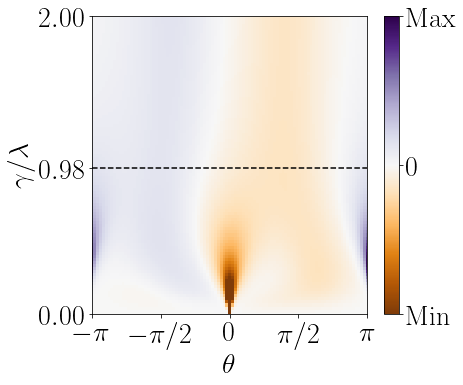

In [74]:
Rx  = loadtxt('Rx.txt',unpack=True) 
Rx  = asmatrix(Rx.T)
Xs  = linspace(-pi,pi,99)
Ys  = linspace(0,2,99) 

if cal_value == True:
    val = 48#where(Rx == amax(Rx))[0][0]
    nval = Ys[val]
    savetxt("gamma_value.txt",[nval],fmt = '%s', comments = '')
    savetxt("cut_value.txt",[val],fmt = '%s', comments = '')
else:
    nval = float(nval)


fig,ax = plt.subplots(figsize=(7,6))
z_min, z_max = Rx.min(), Rx.max()
levels = linspace(-19, 19, 40)
#bar = ax.contourf(Xs, Ys, Rx, cmap='RdBu',levels=levels, vmin=-19, vmax=19)
bar = ax.pcolormesh(Xs, Ys, Rx, cmap='PuOr', vmin=-50, vmax=50)
#bar = ax.imshow(flip(Rx))
#ax.plot([-pi/2,-pi/2],[0,2],ls='--', c='black')
#ax.plot([pi/2,pi/2],[0,2],ls='--', c='black')
ax.plot([-pi,pi],[nval,nval],ls='--', c='black')

ax.axis([Xs.min(), Xs.max(), Ys.min(), Ys.max()])
c = fig.colorbar(bar, ax=ax, ticks=[-50,0,50])
c.set_ticklabels(["Min", "0", "Max"])
ax.set_xlabel('$\\theta$')
ax.set_ylabel('$\gamma/\lambda$')

ax.set_xticks([-pi,-pi/2,0,pi/2,pi])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$'])
ax.set_yticks([0,nval,2])
plt.tight_layout()
plt.savefig('images/current_square_pump.png')
plt.savefig('images/current_square_pump.pdf')

#print(z_min, z_max)
#fig.write_image("images/param_pump_Currenty_{}.png".format(round(nval,2)))

/tmp/ipykernel_43924/2047059833.py:19: MatplotlibDeprecationWarning: For X (100) and Y (100) with flat shading, the expected shape of A is (99, 99). Passing A ((1, 9801)) is deprecated since 3.5 and will become an error two minor releases later.
  bar = ax.pcolormesh(Xs, Ys, Ry, cmap='PuOr', vmin=-50, vmax=50)


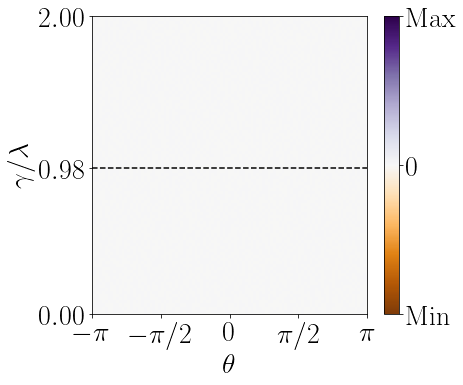

In [63]:
Ry  = loadtxt('Ry.txt',unpack=True) 
Ry  = asmatrix(Ry.T)
Xs  = linspace(-pi,pi,99)
Ys  = linspace(0,2,99) 

if cal_value == True:
    val = 48#where(Rx == amax(Rx))[0][0]
    nval = Ys[val]
    savetxt("gamma_value.txt",[nval],fmt = '%s', comments = '')
    savetxt("cut_value.txt",[val],fmt = '%s', comments = '')
else:
    nval = float(nval)


fig,ax = plt.subplots(figsize=(7,6))
z_min, z_max = Ry.min(), Ry.max()
levels = linspace(-19, 19, 40)
#bar = ax.contourf(Xs, Ys, Rx, cmap='RdBu',levels=levels, vmin=-19, vmax=19)
bar = ax.pcolormesh(Xs, Ys, Ry, cmap='PuOr', vmin=-50, vmax=50)
#bar = ax.imshow(flip(Rx))
#ax.plot([-pi/2,-pi/2],[0,2],ls='--', c='black')
#ax.plot([pi/2,pi/2],[0,2],ls='--', c='black')
ax.plot([-pi,pi],[nval,nval],ls='--', c='black')

ax.axis([Xs.min(), Xs.max(), Ys.min(), Ys.max()])
c = fig.colorbar(bar, ax=ax, ticks=[-50,0,50])
c.set_ticklabels(["Min", "0", "Max"])
ax.set_xlabel('$\\theta$')
ax.set_ylabel('$\gamma/\lambda$')
ax.set_xticks([-pi,-pi/2,0,pi/2,pi])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$'])
ax.set_yticks([0,nval,2])
plt.tight_layout()
plt.savefig('images/current_square_pumpy.png')
plt.savefig('images/current_square_pumpy.pdf')

#fig.write_image("images/param_pump_Currenty_{}.png".format(round(nval,2)))

In [76]:
import plotly.figure_factory as ff
Rx = []
Ry = []
γs = linspace(0,2,100)
γs = delete(γs,0)
for γ in γs:
    Pi_array = linspace(-pi,pi,102)

    H0 = Hoti_Hamiltonian_transport(0.5,Pi_array[1],γ)
    Ek0, U0 = eigh(H0)
    Ek0 = np.real(Ek0)
    s0 = density_of_states(Ek0.T,U0.T, arg='neg')
    n = 0
    jx = []
    jy = []
    for θ in Pi_array[2:-1]:
        H1 = Hoti_Hamiltonian_transport(0.5,θ,γ)
        Ek1, U1 = eigh(H1)
        Ek1 = np.real(Ek1)
        s1 = density_of_states(Ek1.T,U1.T,arg='neg')

        Cx = [] 
        Cy = []
        Cu = [] 
        Cv = []
        for z in np.unique(f):
            find = [j for j,val in enumerate(f) if val == z]
            X = [x[i] for i in find]
            Y = [y[i] for i in find]
            S0 = [s0[i] for i in find]
            S1 = [s1[i] for i in find]
            xmax = np.amax(X)
            xmin = np.amin(X)
            ymax = np.amax(Y)
            ymin = np.amin(Y)
            rx = (xmax + xmin)/2
            ry = (ymax + ymin)/2
            if (rx < 3) and (ry < 3):
                #print("({},{})".format(rx,ry))
                Jx = vdot(subtract(S1,S0),X-rx)
                Jy = vdot(subtract(S1,S0),Y-ry)
                Cx.append(rx)
                Cy.append(ry)
                Cu.append(2000*Jx)
                Cv.append(2000*Jy)

        jx.append(sum(Cu))
        jy.append(sum(Cv))
        U0 = U1 
        Ek0 = Ek1
        s0 = s1  
        n+=1
    Rx.append(jx)
    Ry.append(jy)

savetxt("Rx_neg.txt",Rx,fmt = '%s', comments = '')  
savetxt("Ry_neg.txt",Ry,fmt = '%s', comments = '')  

/tmp/ipykernel_43924/4106755012.py:19: MatplotlibDeprecationWarning: For X (100) and Y (100) with flat shading, the expected shape of A is (99, 99). Passing A ((1, 9801)) is deprecated since 3.5 and will become an error two minor releases later.
  bar = ax.pcolormesh(Xs, Ys, Rx, cmap='PuOr', vmin=-50, vmax=50)


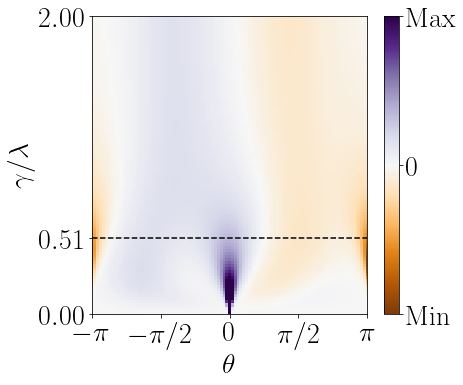

In [77]:
Rx  = loadtxt('Rx_neg.txt',unpack=True) 
Rx  = asmatrix(Rx.T)
Xs  = linspace(-pi,pi,99)
Ys  = linspace(0,2,99) 

if cal_value == True:
    val = 25#where(Rx == amax(Rx))[0][0]
    nval = Ys[val]
    savetxt("gamma_value.txt",[nval],fmt = '%s', comments = '')
    savetxt("cut_value.txt",[val],fmt = '%s', comments = '')
else:
    nval = float(nval)


fig,ax = plt.subplots(figsize=(7,6))
z_min, z_max = Rx.min(), Rx.max()
levels = linspace(-19, 19, 40)
#bar = ax.contourf(Xs, Ys, Rx, cmap='RdBu',levels=levels, vmin=-19, vmax=19)
bar = ax.pcolormesh(Xs, Ys, Rx, cmap='PuOr', vmin=-50, vmax=50)
#bar = ax.imshow(flip(Rx))
#ax.plot([-pi/2,-pi/2],[0,2],ls='--', c='black')
#ax.plot([pi/2,pi/2],[0,2],ls='--', c='black')
ax.plot([-pi,pi],[nval,nval],ls='--', c='black')

ax.axis([Xs.min(), Xs.max(), Ys.min(), Ys.max()])
c = fig.colorbar(bar, ax=ax, ticks=[-50,0,50])
c.set_ticklabels(["Min", "0", "Max"])
ax.set_xlabel('$\\theta$')
ax.set_ylabel('$\gamma/\lambda$')
ax.set_xticks([-pi,-pi/2,0,pi/2,pi])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$'])
ax.set_yticks([0,nval,2])
plt.tight_layout()
plt.savefig('images/current_square_pump_neg.png')
plt.savefig('images/current_square_pump_neg.pdf')

#fig.write_image("images/param_pump_Currenty_{}.png".format(round(nval,2)))

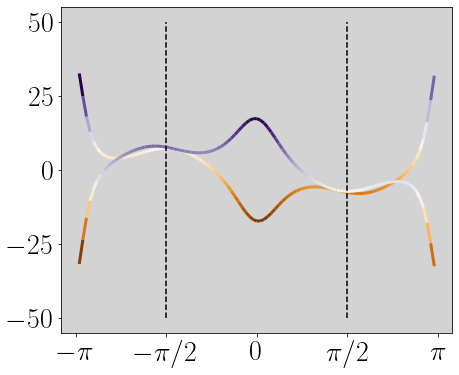

In [78]:
fig,ax = plt.subplots(figsize=(7,6))

Xs  = linspace(-pi,pi,101)[1:-1]

Rx_neg  = loadtxt('Rx_neg.txt',unpack=True)
Rx_neg  = asmatrix(Rx_neg.T)

Rx  = loadtxt('Rx.txt',unpack=True)
Rx  = asmatrix(Rx.T)

CutCx = array(Rx[val]).reshape(99)
CutNCx = array(Rx_neg[val]).reshape(99)
#CutDx = array(M[val]*100).reshape(101)


colorline(Xs,CutCx,ax,CutCx,cmap='PuOr')
colorline(Xs,CutNCx,ax,CutNCx,cmap='PuOr')
#colorline(Xs,CutDx,ax,CutDx,cmap='winter')

ax.plot([-pi/2,-pi/2],[-50,50],ls='--', c='black')
ax.plot([pi/2,pi/2],[-50,50],ls='--', c='black')
#c = fig.colorbar(bar, ax=ax, ticks=[-19,0,19])
#ax.set_yticks([CutCx.min(),0,CutCx.max()])
#ax.set_yticklabels(["Min", "0", "Max"])
#ax.set_ylim((CutCx.min(),CutCx.max()))
#ax.set_ylabel('$\sum_{c}\sum_{cell} (d \\rho_i/dt) R_i\cdot\hat{x}$')
ax.set_xticks([-pi,-pi/2,0,pi/2,pi])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$'])
plt.savefig('images/current_square_pump_pn.png')
plt.savefig('images/current_square_pump_pn.pdf')
ax.set_facecolor('#D3D3D3')

In [79]:
integrate = 0
for i in CutCx:
    integrate += i/len(CutCx)

print(integrate)

-0.763426325152175


In [80]:
integrate = 0
for i in CutNCx:
    integrate += i/len(CutNCx)

print(integrate)

0.7634263251521791


### Simulations

In [32]:
S_array = []
Pi_array = linspace(-pi,pi,51)
for θ in Pi_array:
    H = Hoti_Hamiltonian_transport(0.5,θ,nval)
    Ek, U = eigh(H)
    Ek = np.real(Ek)
    S = density_of_states(Ek.T,U.T, arg='pos') 
    S_array.append(S)

In [33]:
import plotly.figure_factory as ff
nval = 0.5
step = 20
S_array = []
Pi_array = linspace(-pi,pi,step)
for θ in Pi_array:
    H = Hoti_Hamiltonian_transport(A,θ,nval)
    Ek, U = eigh(H)
    Ek = np.real(Ek)
    S = density_of_states(Ek.T,U.T, arg='pos') 
    S_array.append(S)
    
#print(S_array)
H0 = Hoti_Hamiltonian_transport(A,Pi_array[0],nval)
Ek0, U0 = eigh(H0)
Ek0 = np.real(Ek0)
s0 = density_of_states(Ek0.T,U0.T, arg='pos')
n = 0

ArrCx = [] 
ArrCy = []
ArrCu = [] 
ArrCv = []
ArrS  = []
for θ in Pi_array[1:]:
    H1 = Hoti_Hamiltonian_transport(A,θ,nval)
    Ek1, U1 = eigh(H1)
    Ek1 = np.real(Ek1)
    s1 = density_of_states(Ek1.T,U1.T, arg='pos')
    
    Cx = [] 
    Cy = []
    Cu = [] 
    Cv = []
    for z in np.unique(f):
        find = [j for j,val in enumerate(f) if val == z]
        X = [x[i] for i in find]
        Y = [y[i] for i in find]
        S0 = [s0[i] for i in find]
        S1 = [s1[i] for i in find]
        xmax = np.amax(X)
        xmin = np.amin(X)
        ymax = np.amax(Y)
        ymin = np.amin(Y)
        rx = (xmax + xmin)/2
        ry = (ymax + ymin)/2
        Jx = vdot(subtract(S1,S0),X-rx)
        Jy = vdot(subtract(S1,S0),Y-ry)
        Cx.append(rx)
        Cy.append(ry)
        Cu.append(Jx)
        Cv.append(Jy)
        
    ArrCx.append(Cx)
    ArrCy.append(Cy)
    ArrCu.append(Cu)
    ArrCv.append(Cv)
    ArrS.append(s1)
    
    
    U0 = U1 
    Ek0 = Ek1
    s0 = s1  
    n+=1     

/tmp/ipykernel_43924/531019443.py:82: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


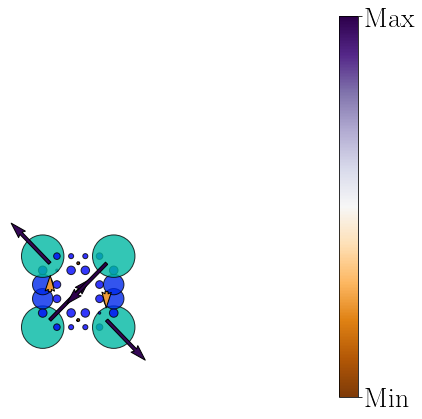

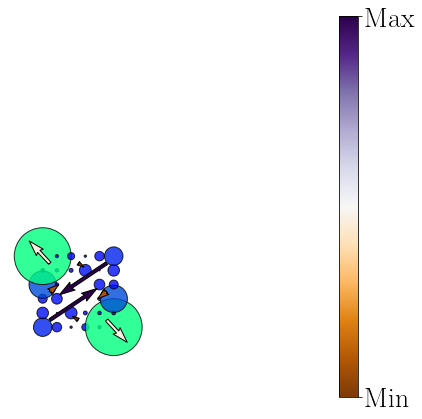

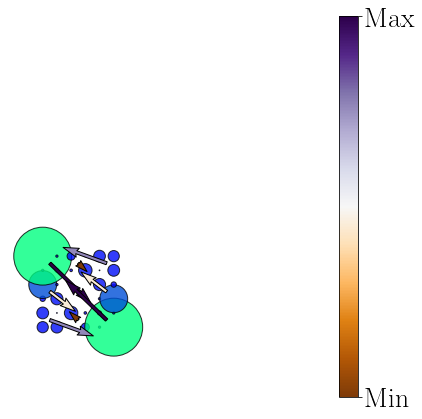

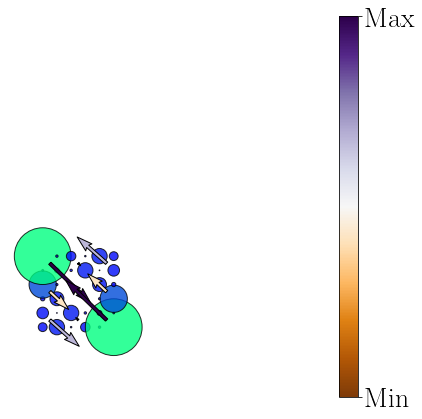

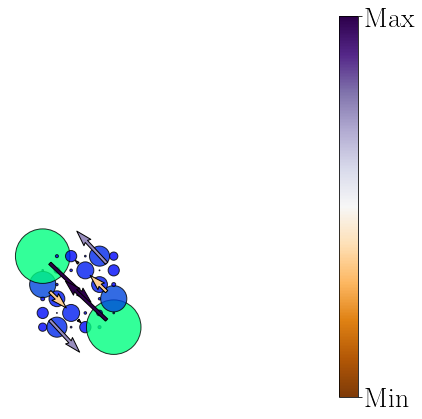

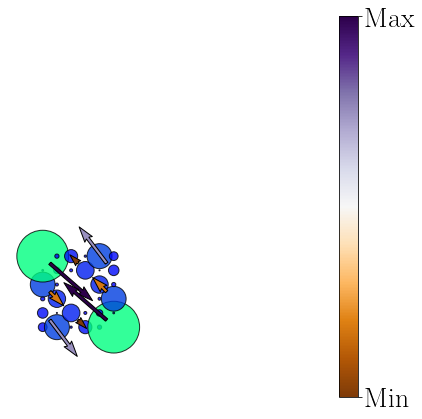

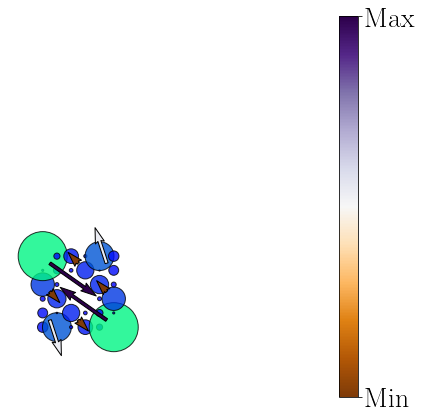

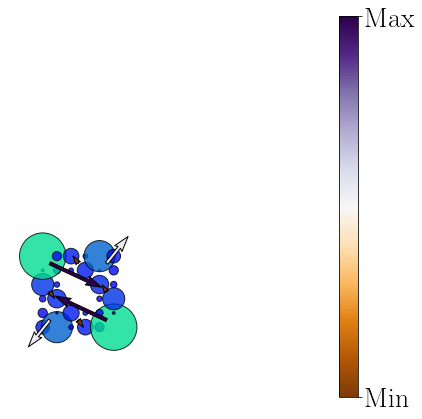

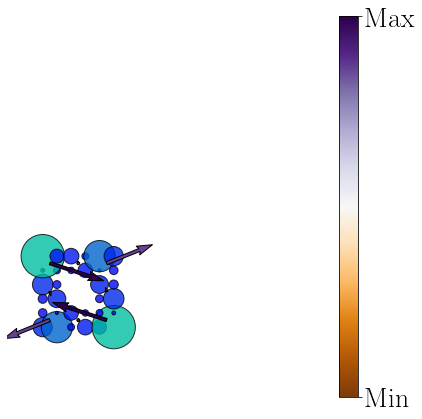

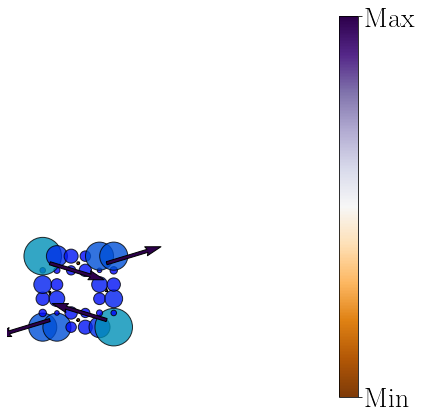

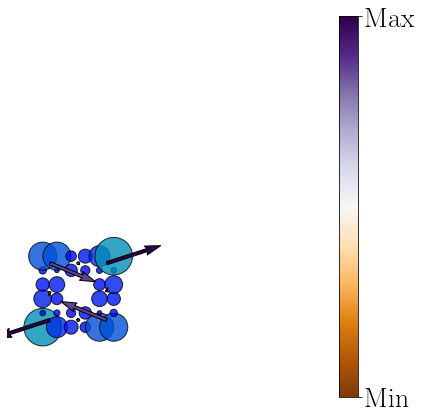

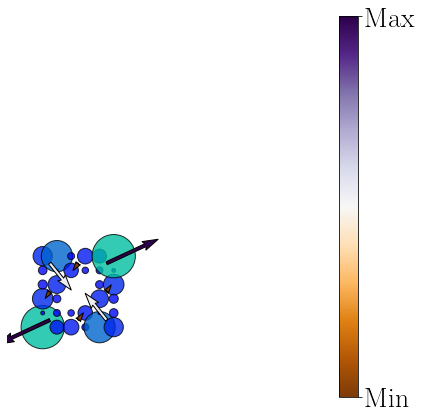

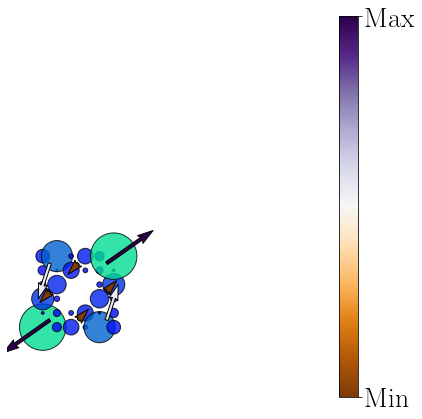

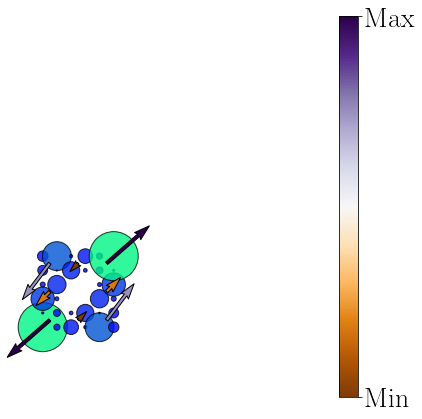

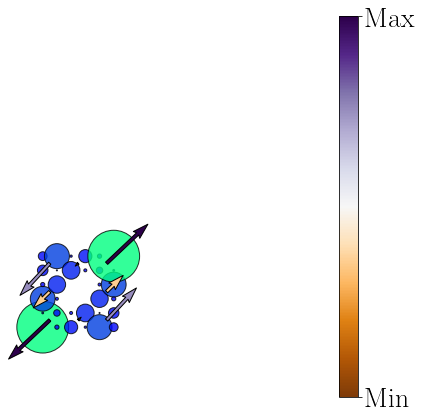

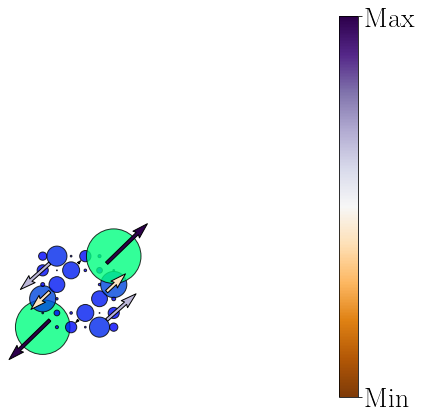

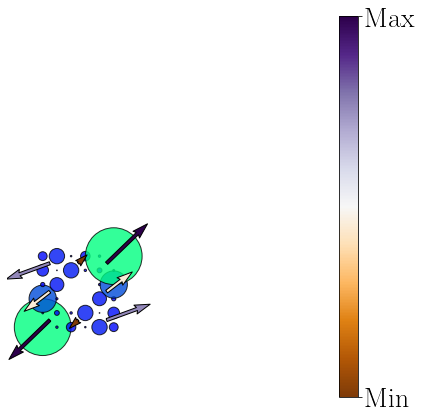

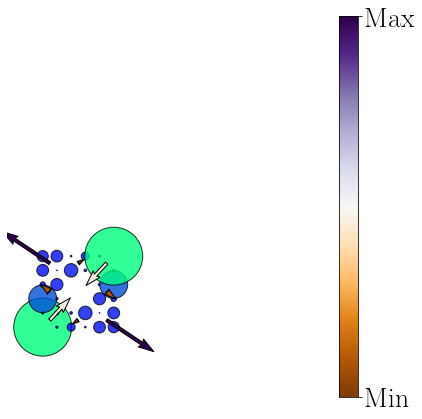

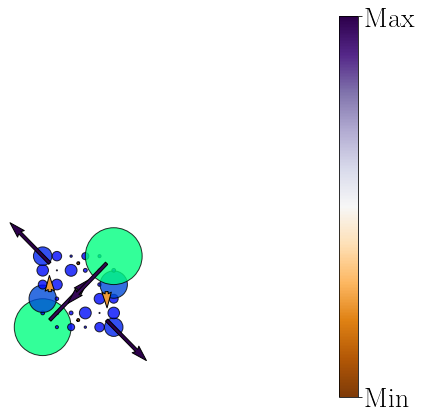

In [34]:
#pip install mycolorpy
from mycolorpy import colorlist as mcp
max_nr = norm([amax(asmatrix(ArrCu)),amax(asmatrix(ArrCv))])

#Rx  = loadtxt('Rx.txt',unpack=True)
#Rx  = asmatrix(Rx.T)
n = len(ArrCx)
#print(Rx[val])

#CutCx = array(Rx[val]).reshape(99)
#CutDx = array(M[val]*100).reshape(101)


for i in range(n):
    Cx  = ArrCx[0]
    Cy  = ArrCy[0]
    Cu  = array(ArrCu[i])
    Cv  = array(ArrCv[i])
    s1  = ArrS[i]
    
    fig, ax = plt.subplots( figsize=(7,7))
    
    #plot corte de parametros    

    #colorline(Xs[1:],CutCx,ax[0],CutCx,cmap='PuOr')
    #colorline(Xs,CutDx,ax[0],CutDx,cmap='winter')
    
    #ax[0].plot([Pi_array[1:][i],Pi_array[1:][i]],[-20,20],ls='--', c='black')
    
    #ax[0].plot([-pi/2,-pi/2],[-20,20], c='black')
    #ax[0].plot([pi/2,pi/2],[-20,20], c='black')
    #c = fig.colorbar(bar, ax=ax, ticks=[-19,0,19])
    #ax[0].set_yticks([CutCx.min(),0,CutCx.max()])
    #ax[0].set_yticklabels(["Min", "0", "Max"])
    #ax[0].set_ylim((CutCx.min(),CutCx.max()))
    #ax.set_ylabel('$\sum_{c}\sum_{cell} (d \\rho_i/dt) R_i\cdot\hat{x}$')
    #ax[0].set_xlabel('$\\theta$')
    #ax[0].set_xticks([-pi,-pi/2,0,pi/2,pi])
    #ax[0].set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$'])
    
    
    #plot proyeccion en el tiempo
    ax.scatter(x,y, s=S_array[i]*10000, alpha=0.8,c=S_array[i], 
                 cmap='winter',edgecolor='black',linewidth = 1,vmin=0, vmax=0.25)
    
    
    nr    = sqrt(Cu*Cu + Cv*Cv)
    size  = log(nr+1)/log(max(nr)+1)
     
    #color=mcp.gen_color(cmap="hot",n=101)  
    #norm = matplotlib.colors.Normalize()
    #norm.autoscale(CutCx)
    
    norm = matplotlib.colors.Normalize()
    norm.autoscale(nr)
    color = matplotlib.cm.PuOr

    sm = matplotlib.cm.ScalarMappable(cmap=color, norm=norm)
    sm.set_array([])
    
    
    Indexcolor = [Cu[i] for i in range(len(Cx)) if Cx[i]<9 and Cy[i]<9]
    indexcolor = int(norm(sum(Indexcolor)*200)*51)
    
    #print(indexcolor)
    
    Q = ax.quiver(Cx,Cy, size*Cu/nr,size*Cv/nr, scale_units='xy', scale=0.25, 
                 width=0.01,color=color(norm(nr)), edgecolor='black', linewidth = 1)
    #ax[0].scatter([Pi_array[1:][i]],[sum(Indexcolor)*200])
    c = fig.colorbar(sm, ax=ax, ticks=[min(nr), max(nr)])
    c.set_ticklabels(["Min", "Max"])
    
    #ax[1].set_facecolor('#D3D3D3')
    ax.set_xlim((-2.5,19.5))
    ax.set_ylim((-2.5,19.5))
    ax.set_aspect('equal')
    ax.axis("off")


    fig.savefig('images/video_images/hoti_pomp_cut{}.pdf'.format(i))
    fig.savefig('images/video_images/hoti_pomp_cut{}.png'.format(i))
    fig.show()
   

   


# Simulacion

# Centros de wannier

In [35]:
x,y,f,d = np.loadtxt(name_array,usecols=(1,2,4,5),skiprows=2,unpack=True)


In [36]:
dic_rx = dict.fromkeys(range(len(x)))
dic_ry = dict.fromkeys(range(len(y)))
for i in unique(f):
    rx = reshape(argwhere(f == i),(len(argwhere(f == i))))
    px = mean(x[rx])
    py = mean(y[rx])
    
    for j in rx:
    
        dic_rx[j] = px-0.5
        dic_ry[j] = py-0.5
        

Lx = array([sum(dic_rx[i]) for i in dic_rx.keys()])
Lxmax = max(Lx)
Lx = Lx/max(Lx)
 
    
Ly = array([sum(dic_ry[i]) for i in dic_ry.keys()])
Lymax = max(Ly)
Ly = Ly/max(Ly)

$$\hat{x} = exp(i2\pi (x)/L)$$
$$\hat{y} = exp(i2\pi (y)/L)$$

In [37]:
POSx=matrix(diag(exp(2*pi*1j*Lx)))
POSy=matrix(diag(exp(2*pi*1j*Ly)))

#POSx=matrix(diag(Lx))
#POSy=matrix(diag(Ly))


Lwanflow=[]
Hwanflow=[]
Lwane=[]
Hwane=[]
for θ in linspace(-pi,pi,51):
    H=matrix(Hoti_Hamiltonian_transport(0.5,θ,0.98,conection=True))
    sys=eigh(H)

    Lval=sys[0][sys[0]<0]
    Lvec=matrix(sys[1][:,sys[0]<0])
    LP=Lvec*Lvec.H
    LW=LP*(POSx*POSy)*LP
    LWval,LWvec=eig(LW)
    LWvec=LWvec[:,abs(LWval)>1e-10]
    LWe=real(diag(LWvec.H*H*LWvec))
        
    Hval=sys[0][sys[0]>0]
    Hvec=matrix(sys[1][:,sys[0]>0])
    HP=Hvec*Hvec.H
    HW=HP*(POSx*POSy)*HP
    HWval,HWvec=eig(HW)
    
    HWvec=HWvec[:,abs(HWval)>1e-10]
    HWe=real(diag(HWvec.H*H*HWvec))
    
    #print(shape(Lxmax/(2*pi)*sort(angle(HWval[abs(HWval)>1e-10]))))
    
    Hwanflow.append(Lxmax/(2*pi)*sort(angle(HWval[abs(HWval)>1e-10])))
    Lwanflow.append(Lxmax/(2*pi)*sort(angle(LWval[abs(LWval)>1e-10])))

Hwanflow = array(Hwanflow)
Lwanflow = array(Lwanflow)


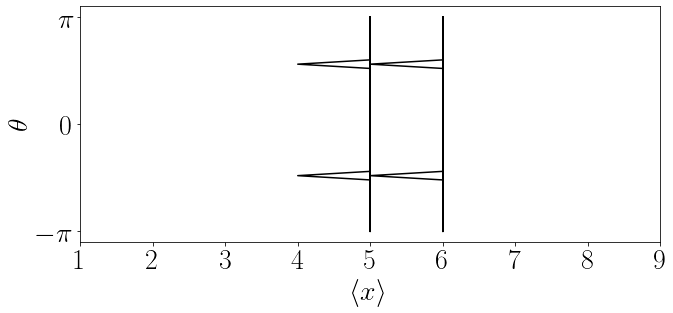

In [38]:
fig, ax = subplots(figsize=(10,5))
for i in range(len(Hwanflow[0])):
    
    xa = Hwanflow.T[i]
    xL = Lwanflow.T[i]
    #print(xa)
    ya = linspace(-pi,pi,len(xa))
    ax.plot(xa,ya,c='black')
    #ax.plot(xL,ya,c='r')
ax.set_xlabel('$\langle x \\rangle$')
ax.set_ylabel('$\\theta$')
ax.set_yticks([-pi,0,pi])
ax.set_xticks(arange(-8,10,2))
ax.set_yticklabels(['$-\pi$','0','$\pi$'])
ax.set_xticklabels(['1','2','3','4','5','6','7','8','9'])
fig.tight_layout()
fig.savefig('images/wannier_center.pdf')
fig.savefig('images/wannier_center.png')
    

(3.5, 4.5)

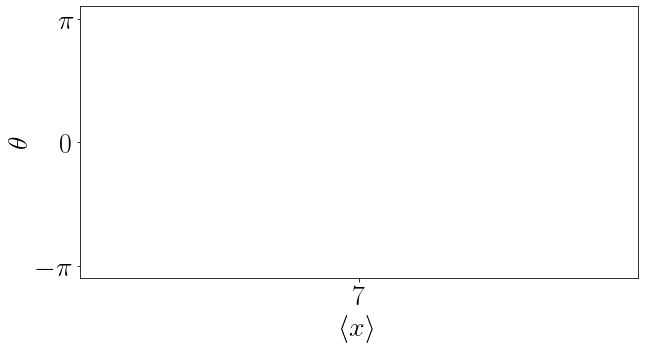

In [39]:
fig, ax = subplots(figsize=(10,5))
for i in range(len(Hwanflow[0])):
    
    xa = Hwanflow.T[i]
    xL = Lwanflow.T[i]
    #print(xa)
    ya = linspace(-pi,pi,len(xa))
    ax.plot(xa,ya,c='black')
    #ax.plot(xL,ya,c='r')
ax.set_xlim(3,4)
ax.set_xlabel('$\langle x \\rangle$')
ax.set_ylabel('$\\theta$')
ax.set_yticks([-pi,0,pi])
ax.set_xticks(arange(-8,10,2))
ax.set_yticklabels(['$-\pi$','0','$\pi$'])
ax.set_xticklabels(['1','2','3','4','5','6','7','8','9'])
ax.set_xlim(3.5,4.5)

#fig.savefig('images/wannier_center.pdf')